$ \textbf{Script we use to analyze the data we stored during the characterization measures.}$

In [11]:
import cmath
import math
from iminuit.cost import LeastSquares
from iminuit import cost
from iminuit import Minuit, cost
import numpy as np
from matplotlib import pyplot as plt
import h5py
from PIL import Image
import scipy.special as ss
import scipy.constants as sc

def ampl(i, q):
    return np.power((np.power(q, 2) + np.power(i, 2)), 1/2)

def phase(i, q):
    return(np.arctan(q / i))

def amp_model(x, p1 , p2 , p3, p4, p5, p6,  p7, p8):
    return (p6*(x) + p7*x**2 + p8*x**3) + abs(p1*(1 - cmath.exp(1j*p4)*p2*(p2**-1 - p3**-1) / (1 + 2j * p2 * ( x - p5 ) / f_min[0] )))

def new_amp_model(x, p1, p2 , p3, p4, p5, p6,  p7, p8):
    return (p6*x + p7*x**2 + p8*x**3) + p1 * abs ((1 - (1 - p2 / p3) * cmath.exp(1j*p4) / (1 + 2j * p2 * ( x - p5 ) / p5 )))

def inv_Qi_model(x, p1, p2, p3, p4):        # DOVETE CAPIRE QUALE SIA IL SEGNO DELL'ARG DI I_0
    return  1/p1 + (2*p2*np.exp(-p3/(sc.k*x))*2*np.sinh(sc.hbar*p4/(2*sc.k*x))*ss.kv(0, sc.hbar*p4/(2*sc.k*x)))/(np.pi*(1-2*np.exp(-p3/(sc.k*x))*np.exp(-sc.hbar*p4/(2*sc.k*x))*ss.iv(0,sc.hbar*p4/(2*sc.k*x))))

def plot_amp_and_phase(i, q, f, number_res):        # Plots the amplitude vs f and phase vs f for a single resonator given the i, q, f values
    fig, (ax1, ax2) = plt.subplots(1, 2)            # And that's for the resonator number 'number_res + 1'
    fig.suptitle("Plots relative to the resonator number " + str(number_res + 1) + "\n\n\n")

    ax1.plot(f, amp, label = 'Amplitude vs f')
    ax1.set_title( "Amplitude")
    ax1.set_xlabel("f [GHz]")
    ax1.set_ylabel("Amplitude")

    fig.subplots_adjust(wspace=.4)

    ax2.set_title("Phase")
    ax2.set_xlabel("f [GHz]")
    ax2.set_ylabel("$\Phi \; [rad]$")

    plt.plot(f, phase(i, q), label = 'Phase vs f')
    plt.show()
    
def get_single_res_data(h5file, temp, freq_window, number_res):     # Allows to get important data from the hdf5 file
    f1 = freq_window[number_res * 2]
    f2 = freq_window[number_res * 2 + 1]
    f = h5file['Temp_' + str(temp) + 'mK']['temp_' + str(temp) + 'mK_Start' + str(f1) + '_Stop' + str(f2) + 'GHz']['freqs'][number_res, :]
    i = h5file['Temp_' + str(temp) + 'mK']['temp_' + str(temp) + 'mK_Start' + str(f1) + '_Stop' + str(f2) + 'GHz']['I'][:]
    q = h5file['Temp_' + str(temp) + 'mK']['temp_' + str(temp) + 'mK_Start' + str(f1) + '_Stop' + str(f2) + 'GHz']['Q'][:]
    return f, i, q
    
def plot_data_and_fit(freqs, original_data, fitted_points, original_data_err = 0., x_axis = 'frequency [GHz]', y_axis = 'magnitude $S_{21}$', title = 'Amplitude vs frequency'):     # Plots superposition of fit and data
    plt.errorbar(freqs, original_data, yerr = original_data_err, xerr=None, marker='o', markersize=.8, barsabove=True, elinewidth=.8, capsize=.8, linewidth=0, label = 'data')
    plt.title(title)
    plt.xlabel(x_axis)
    plt.ylabel(y_axis)
    plt.plot(freqs, fitted_points, label = 'fit')
    #plt.xlim(-0.0015, 0.0015)
    #plt.title('Superposition of original data and fit')
    plt.show()
    
def fit_amp_data(f_transl, amp, amp_err, amp_model):            # Performs the fit on our data for a single resonance
    least_squares = LeastSquares(f_transl, amp, amp_err, amp_model)
    m = Minuit(least_squares, p1 = 1, p2 = 1e3, p3 =  6e4, p4 = -0.5, p5 = 0, p6 = -1e-9,  p7 = -1e-19, p8 = 0)  # starting values for our parameters
    m.limits['p2'] = (1e3, 1e7)
    m.limits['p3'] = (1e3, 1e7)
    m.limits['p5'] = (-0.02, 0.02)
    fit = m.migrad()        #This is the command that performs the fit
    return fit, m

def fit_check(m):
    valid, accurate = m.valid, m.accurate
    return valid, accurate

def new_fit(f, amp, amp_err, new_amp_model): # new fit which is performed without frequency tranlsation
    least_squares = LeastSquares(f, amp, amp_err, new_amp_model)
    m = Minuit(least_squares, p1 = 1, p2 = 1e4, p3 = 6e4, p4 = -0.5, p5 = 5.5, p6 = -1e2,  p7 = -5e4, p8 = 1e-1)  # starting values for our parameters
    m.limits['p2'] = (1e3, 1e7)
    m.limits['p3'] = (1e3, 1e7)
    m.limits['p5'] = (5.2, 6.0)
    
    fit = m.migrad()        # This is the command that performs the fit
    return fit, m    

def fit_Qi_vs_temp(temp, inv_Q_i, inv_Q_i_err, suggestions):
    least_squares = LeastSquares(temp, inv_Q_i, inv_Q_i_err, inv_Qi_model)
    m = Minuit(least_squares, p1 = suggestions[0 , res], p2 = suggestions[3 , res], p3 = suggestions[6 , res], p4 = suggestions[9, res])  # starting values for our parameters
    m.limits['p1'] = (suggestions[1 , res], suggestions[2 , res])           
    m.limits['p2'] = (suggestions[4 , res], suggestions[5 , res])
    m.limits['p3'] = (suggestions[7 , res], suggestions[8 , res])
    fit = m.migrad()        # This is the command that performs the fit
    return fit, m 



freq_window = np.array([5.340, 5.355, 5.568, 5.583, 5.667, 5.682, 5.978, 5.987])

First we get back the data we had stored in the hdf5 files.
Then we have to try and fit the data regarding the $\textbf{AMPLITUDE}. \\$
We start to handle and clean a bit our data. $\\$
We translate the frequency axis so that the minimum of the resonance curve stays occurs at the frequency zero. The fit should have less trouble if it works with small numbers. $\\$
We also rescale the amplitude values in order to get them always lower than 1. $\\$

The formula which relates $S_{12}$ to the frequency is the following: $\\$
$ S_{21}(f) = I + jQ = P_n(f) \bigg[1 - Q \bigg(\frac{1}{Q} - \frac{1}{Q_i} \bigg) \frac{e^{j \, \Phi_0}}{1 - 2j \, Q \frac{f - f_0}{f_0}} \bigg] =  P_n(f) \bigg[1 -  \bigg( 1 - \frac{Q}{Q_i} \bigg) \frac{e^{j \, \Phi_0}}{1 - 2j \, Q \frac{f - f_0}{f_0}} \bigg]  \\ $

So, in our model, we will have:

$p_1 \longrightarrow P_n(f) \\ 
p_2 \longrightarrow Q  \hspace{1.5cm} \text{lim}: \; 1e3 < Q < 1e7\\
p_3 \longrightarrow Q_i \hspace{1.4cm} \text{lim}: \; 1e3 < Q_i < 1e7\\
p_4 \longrightarrow \Phi_0  \\
p_5 \longrightarrow f_0 \hspace{1.5cm} \text{lim}: \; 5.2 < f_0 < 6.0\\
p_6, \, p_7, \, p_8 \, \longrightarrow$ coefficients of the polynomial background 


We are going to fit the module of $S_{21}$, which is the amplitude. And we will also add a polynomial (order $3$) to interpolate the background [??? Is it fine that we don't use a $p_9$ as a free coefficient ???] . So the model becomes: $\\$

$ \color{red} \text{amp} = \text{background} +|S_{21}| = p_6 \,f + p_7 \, f^2 + p_8 \, f^3 + \bigg| P_n(f) \bigg[1 -  \bigg( 1 - \frac{Q}{Q_i} \bigg) \frac{e^{j \, \Phi_0}}{1 - 2j \, Q \frac{f - f_0}{f_0}} \bigg] \bigg|  \\ $

How do we associate uncertainties which make sense to our measurements? $\\$

We're going to be interested mainly in $p_3$, which is the $Q_i \, .\\$

Different cells do slightly different things. Read above each cell to understand what it does.




$\\ \color{blue} \textbf{Fit the four resonances for a FIXED temperature.}\\$

Works with either old or new measurements, just remember to change the date.


In [ ]:
# Set parameters to open the correct file and define necessary variables
temp = 45
date = 'Feb_17_2023-17_42_07'
res_numb = 0

amp = np.zeros(1601)
Q_i = np.zeros(4)

# Open hdf5 file
h5file = h5py.File('Values_different_frequency_sweeps_' + str(temp) + 'mK' + str(date) + '.h5', 'r')

# Access the data in the file of the specified temperature. Store the data of all 4 resonators
for k in range(4):

    f, i, q = get_single_res_data(h5file, temp, freq_window, k)

    # Plot amplitude and phase vs f profiles
    #plot_amp_and_phase(i, q, f, k)

    '''plt.plot(f, i)
    plt.plot(f, q)
    S_21 = i + 1j * q
    print(S_21)
    plt.plot(f, abs(S_21))
    plt.show()'''
    
    # Normalize and translate the data so the resonance has the minimum at zero  frequency
    amp = ampl(i,q)
    amp = amp / max(amp)
    f_min = f[np.where(amp == min(amp))]
    f_transl = f - f_min

    # Association of uncertainties to our amplitude measures
    amp_err = 0.02 * np.ones(len(f))            

    # Perform the fit of the resonance profile with our model
    fit, m = fit_amp_data(f_transl, amp, amp_err, amp_model)
    print(fit)

    # Plot data and fit superposed
    plot_data_and_fit(f_transl, amp, amp_model(f_transl, *m.values))

    # Print the values of the Qi estimated via fit
    Q_i[k] = fit.values["p3"]
    print('The value of Qi for the resonator number ' + str(k + 1) + ' is: ' + str(Q_i[k]))

$\\ \color{blue} \textbf{Fit the four resonances for EACH temperature.}\\$

Here we try to handle ALL the data at the same time. You have to remember to create the correct vector 'temps'. The software should be instructed to open the correct files, once the 'temps' vectors is specified.

Operation on temperature 35mK completed
Operation on temperature 40mK completed
Il valore di Q_i per la risonanza numero 1 e per la temperatura 45mK è:431636.902609299
┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 189.6 (chi2/ndof = 0.1)    │              Nfcn = 633              │
│ EDM = 7.91e-05 (Goal: 0.0002)    │            time = 0.2 sec            │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │        No Parameters at limit        │
├──────────────────────────────────┼──────────────────────────────────────┤
│ Below EDM threshold (goal x 10)  │           Below call limit           │
├───────────────┬──────────────────┼───────────┬─────────────┬────────────┤
│  Covariance   │     Hesse ok     │ Accurate  │  Pos. def.  │ Not force

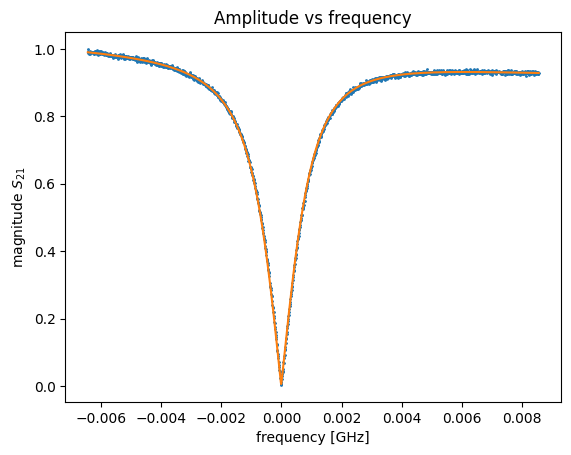

Il valore di Q_i per la risonanza numero 1 e per la temperatura 45mK è:73734.71678235824
┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 309 (chi2/ndof = 0.2)      │              Nfcn = 622              │
│ EDM = 3.09e-05 (Goal: 0.0002)    │            time = 0.2 sec            │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │        No Parameters at limit        │
├──────────────────────────────────┼──────────────────────────────────────┤
│ Below EDM threshold (goal x 10)  │           Below call limit           │
├───────────────┬──────────────────┼───────────┬─────────────┬────────────┤
│  Covariance   │     Hesse ok     │ Accurate  │  Pos. def.  │ Not forced │
└───────────────┴──────────────────┴───────────┴─────────────┴────────────┘

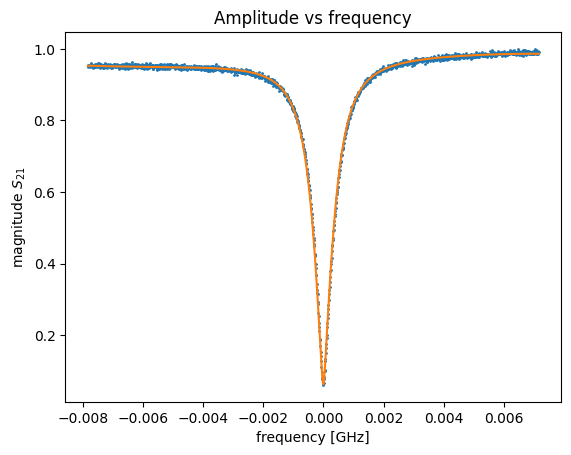

Il valore di Q_i per la risonanza numero 1 e per la temperatura 45mK è:37493.9570336912
┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 218.3 (chi2/ndof = 0.1)    │              Nfcn = 649              │
│ EDM = 2.93e-06 (Goal: 0.0002)    │            time = 0.2 sec            │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │        No Parameters at limit        │
├──────────────────────────────────┼──────────────────────────────────────┤
│ Below EDM threshold (goal x 10)  │           Below call limit           │
├───────────────┬──────────────────┼───────────┬─────────────┬────────────┤
│  Covariance   │     Hesse ok     │ Accurate  │  Pos. def.  │ Not forced │
└───────────────┴──────────────────┴───────────┴─────────────┴────────────┘


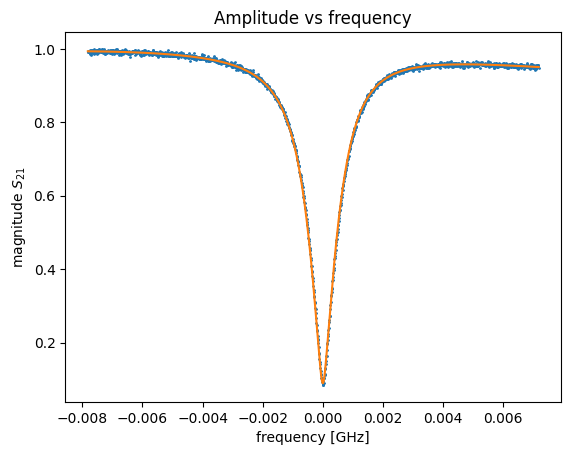

Il valore di Q_i per la risonanza numero 1 e per la temperatura 45mK è:64232.24121733635
┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 891.3 (chi2/ndof = 0.6)    │              Nfcn = 555              │
│ EDM = 9.42e-06 (Goal: 0.0002)    │            time = 0.2 sec            │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │        No Parameters at limit        │
├──────────────────────────────────┼──────────────────────────────────────┤
│ Below EDM threshold (goal x 10)  │           Below call limit           │
├───────────────┬──────────────────┼───────────┬─────────────┬────────────┤
│  Covariance   │     Hesse ok     │ Accurate  │  Pos. def.  │ Not forced │
└───────────────┴──────────────────┴───────────┴─────────────┴────────────┘

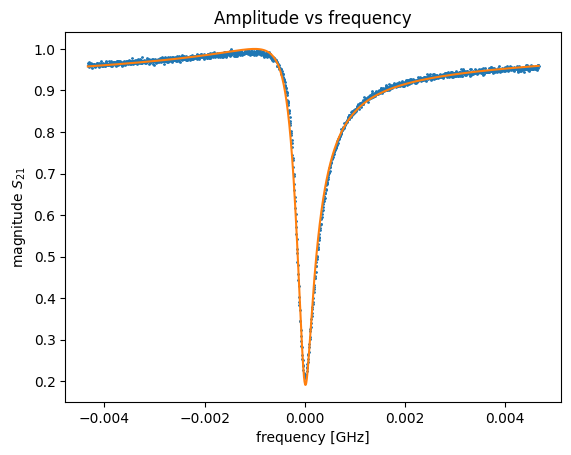

Operation on temperature 45mK completed
Operation on temperature 50mK completed
Operation on temperature 55mK completed
Operation on temperature 60mK completed
Operation on temperature 65mK completed
Operation on temperature 70mK completed
Il valore di Q_i per la risonanza numero 1 e per la temperatura 75mK è:287076.30065004324
┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 199.4 (chi2/ndof = 0.1)    │             Nfcn = 1011              │
│ EDM = 1.41e-11 (Goal: 0.0002)    │            time = 0.2 sec            │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │        No Parameters at limit        │
├──────────────────────────────────┼──────────────────────────────────────┤
│ Below EDM threshold (goal x 10)  │           Below call limi

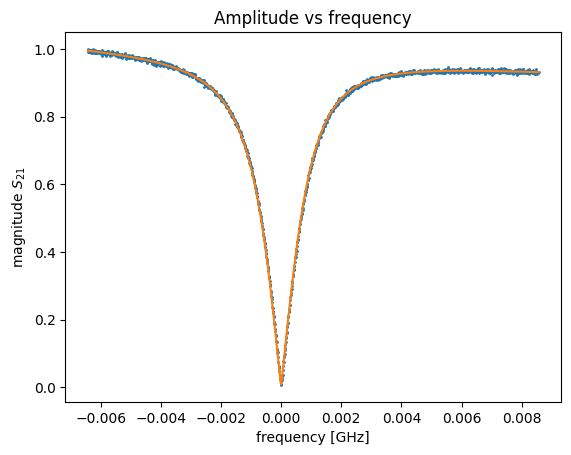

Il valore di Q_i per la risonanza numero 1 e per la temperatura 75mK è:74763.46915656101
┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 277 (chi2/ndof = 0.2)      │              Nfcn = 698              │
│ EDM = 3.55e-05 (Goal: 0.0002)    │            time = 0.3 sec            │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │        No Parameters at limit        │
├──────────────────────────────────┼──────────────────────────────────────┤
│ Below EDM threshold (goal x 10)  │           Below call limit           │
├───────────────┬──────────────────┼───────────┬─────────────┬────────────┤
│  Covariance   │     Hesse ok     │ Accurate  │  Pos. def.  │ Not forced │
└───────────────┴──────────────────┴───────────┴─────────────┴────────────┘

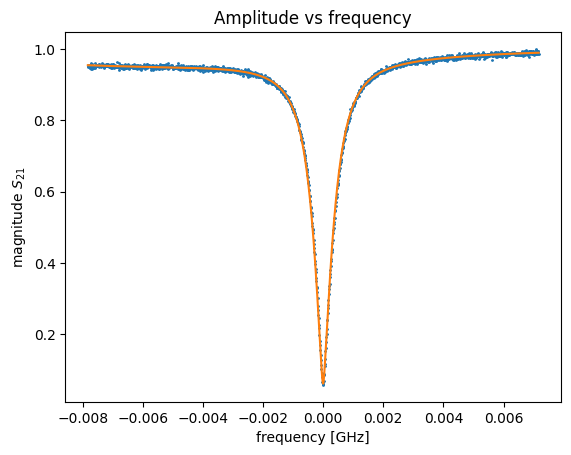

Il valore di Q_i per la risonanza numero 1 e per la temperatura 75mK è:36948.31949274291
┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 207.5 (chi2/ndof = 0.1)    │              Nfcn = 610              │
│ EDM = 1.78e-05 (Goal: 0.0002)    │            time = 0.2 sec            │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │        No Parameters at limit        │
├──────────────────────────────────┼──────────────────────────────────────┤
│ Below EDM threshold (goal x 10)  │           Below call limit           │
├───────────────┬──────────────────┼───────────┬─────────────┬────────────┤
│  Covariance   │     Hesse ok     │ Accurate  │  Pos. def.  │ Not forced │
└───────────────┴──────────────────┴───────────┴─────────────┴────────────┘

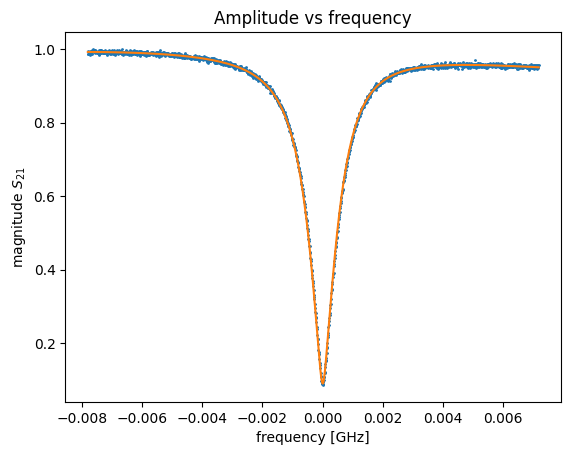

Il valore di Q_i per la risonanza numero 1 e per la temperatura 75mK è:64421.99516042578
┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 839.3 (chi2/ndof = 0.5)    │              Nfcn = 749              │
│ EDM = 1.67e-05 (Goal: 0.0002)    │            time = 0.2 sec            │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │        No Parameters at limit        │
├──────────────────────────────────┼──────────────────────────────────────┤
│ Below EDM threshold (goal x 10)  │           Below call limit           │
├───────────────┬──────────────────┼───────────┬─────────────┬────────────┤
│  Covariance   │     Hesse ok     │ Accurate  │  Pos. def.  │ Not forced │
└───────────────┴──────────────────┴───────────┴─────────────┴────────────┘

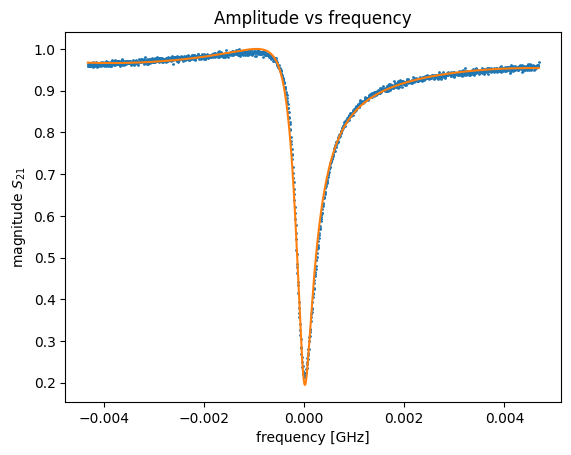

Operation on temperature 75mK completed
Operation on temperature 80mK completed
Operation on temperature 85mK completed
Operation on temperature 90mK completed
Operation on temperature 95mK completed
Operation on temperature 100mK completed
Operation on temperature 105mK completed
Operation on temperature 110mK completed
Il valore di Q_i per la risonanza numero 1 e per la temperatura 115mK è:365626.8511800191
┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 194.6 (chi2/ndof = 0.1)    │              Nfcn = 744              │
│ EDM = 6.87e-05 (Goal: 0.0002)    │            time = 0.1 sec            │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │        No Parameters at limit        │
├──────────────────────────────────┼───────────────────

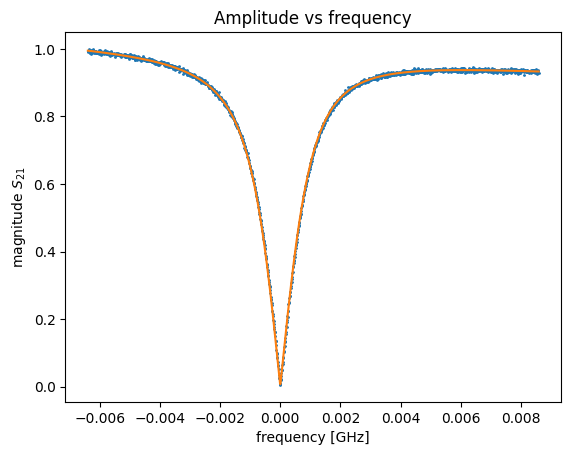

Il valore di Q_i per la risonanza numero 1 e per la temperatura 115mK è:66049.86598402282
┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 309.7 (chi2/ndof = 0.2)    │              Nfcn = 602              │
│ EDM = 1.76e-06 (Goal: 0.0002)    │            time = 0.2 sec            │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │        No Parameters at limit        │
├──────────────────────────────────┼──────────────────────────────────────┤
│ Below EDM threshold (goal x 10)  │           Below call limit           │
├───────────────┬──────────────────┼───────────┬─────────────┬────────────┤
│  Covariance   │     Hesse ok     │ Accurate  │  Pos. def.  │ Not forced │
└───────────────┴──────────────────┴───────────┴─────────────┴────────────

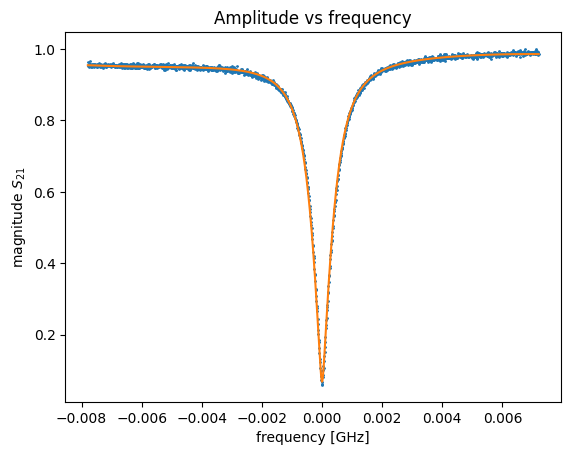

Il valore di Q_i per la risonanza numero 1 e per la temperatura 115mK è:36047.832380082
┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 223.9 (chi2/ndof = 0.1)    │              Nfcn = 591              │
│ EDM = 2.42e-05 (Goal: 0.0002)    │            time = 0.2 sec            │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │        No Parameters at limit        │
├──────────────────────────────────┼──────────────────────────────────────┤
│ Below EDM threshold (goal x 10)  │           Below call limit           │
├───────────────┬──────────────────┼───────────┬─────────────┬────────────┤
│  Covariance   │     Hesse ok     │ Accurate  │  Pos. def.  │ Not forced │
└───────────────┴──────────────────┴───────────┴─────────────┴────────────┘


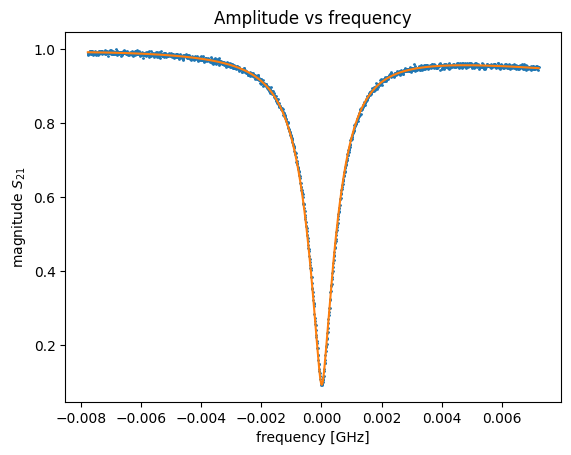

Il valore di Q_i per la risonanza numero 1 e per la temperatura 115mK è:59355.54147811598
┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 1396 (chi2/ndof = 0.9)     │              Nfcn = 602              │
│ EDM = 0.000135 (Goal: 0.0002)    │            time = 0.2 sec            │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │        No Parameters at limit        │
├──────────────────────────────────┼──────────────────────────────────────┤
│ Below EDM threshold (goal x 10)  │           Below call limit           │
├───────────────┬──────────────────┼───────────┬─────────────┬────────────┤
│  Covariance   │     Hesse ok     │ Accurate  │  Pos. def.  │ Not forced │
└───────────────┴──────────────────┴───────────┴─────────────┴────────────

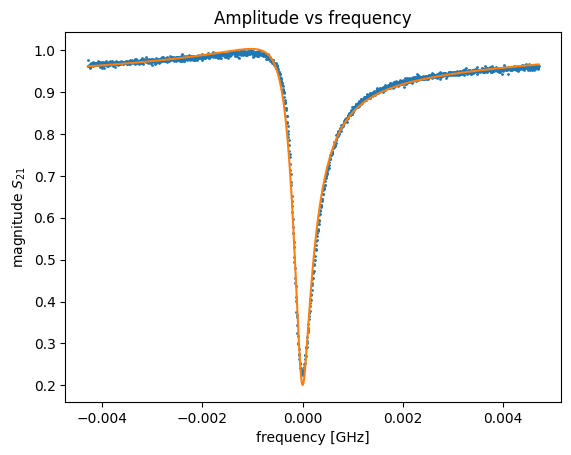

Operation on temperature 115mK completed
Operation on temperature 118mK completed
Operation on temperature 123mK completed
Operation on temperature 128mK completed
Operation on temperature 133mK completed
Operation on temperature 138mK completed
Operation on temperature 143mK completed
Operation on temperature 148mK completed
Operation on temperature 153mK completed
Operation on temperature 158mK completed
Operation on temperature 163mK completed
Operation on temperature 168mK completed
Operation on temperature 173mK completed
Operation on temperature 178mK completed
Operation on temperature 183mK completed
Operation on temperature 188mK completed
Operation on temperature 193mK completed
Operation on temperature 198mK completed
Operation on temperature 203mK completed
Operation on temperature 208mK completed
Operation on temperature 218mK completed
Operation on temperature 228mK completed
Operation on temperature 238mK completed
Operation on temperature 248mK completed
Operation on tem

In [13]:
# Set parameters to open the correct file and define necessary variables
temps = np.arange(35, 120, 5)       # don't know why doesn't stop at 208 but at 203, not a problem though
temps = np.append(temps, np.arange(118, 208, 5))
temps = np.append(temps, np.arange(208, 268, 10))

amp = np.zeros(1601)
Q_i = np.zeros(shape = (len(temps),4))
Q_i_err = np.zeros(shape = (len(temps),4))
date = np.array(['Feb_17_2023-17_42_07','Feb_16_2023-16_06_46', 'Feb_17_2023-10_01_04', 'Feb_17_2023-11_17_43', 'Feb_17_2023-14_19_39', 'Feb_17_2023-15_43_52', 'Feb_17_2023-15_56_04' ])
j = 0           # index that counts the temperatures
res_freqs = np.zeros(4)


for temp in temps:       
    i = 0

    # Open the correct hdf5 file
    while i < len(date):
        try:
            h5file = h5py.File('Values_different_frequency_sweeps_' + str(temp) + 'mK' + str(date[i]) + '.h5', 'r')
            break
        except:
            try: 
                h5file = h5py.File('sweeps_' + str(temp) + 'mK' + str(date[i]) + '.h5', 'r')
                break
            except: i +=1

    # Access the data in the file of the specified temperature. Store the data of all 4 resonators
    for k in range(4):

        f, i, q = get_single_res_data(h5file, temp, freq_window, k)

        # Plot amplitude and phase vs f profiles
        #plot_amp_and_phase(i, q, f, k)
        
        # Normalize and translate the data so the resonance has the minimum at zero  frequency
        amp = ampl(i,q)
        amp = amp / max(amp)
        f_min = f[np.where(amp == min(amp))]
        f_transl = f - f_min

        # Association of uncertainties to our amplitude measures
        if temp%5 == 0:
            amp_err = 0.01 * np.ones(len(f))
        else:
            amp_err = 0.015 * np.ones(len(f))          

        # Perform the fit of the resonance profile with our model
        fit, m = fit_amp_data(f_transl, amp, amp_err, amp_model)
        valid, accurate = fit_check(m)
        if(valid == False or accurate == False):
            print('There has been some trouble with the fit at temperature ' + str(temp) + ' mK of the resonance number ' + str(k+1) +'. \n Make a check!' )
        Q_i[j][k] = fit.values["p3"]
        error_p3 = fit.errors["p3"]
        Q_i_err[j][k] = error_p3
        if (temp==45 or temp == 75 or temp == 115):
            print('Il valore di Q_i per la risonanza numero ' + str(1) + ' e per la temperatura ' + str(temp) + 'mK è:' + str(Q_i[j][k]))
            print(fit)
            print('Errore su p3. ' + str(error_p3) + '\n')
            print('Errore su Q_i. ' + str(Q_i_err[j][k]) + '\n')
            print('Risonatore numero', str(k+1))
            plot_data_and_fit(f_transl, amp, amp_model(f_transl, *m.values))
        #print('The value of Qi for the resonator number ' + str(k + 1) + ' is: ' + str(Q_i[k]))
        if temp == min(temps):
            res_freqs[k] = f_min
    print('Operation on temperature ' + str(temp) + 'mK completed')
    h5file.close()
    j += 1

inv_Q_i = 1 / Q_i
inv_Q_i_err = Q_i_err / Q_i / Q_i
temps = 1e-3*temps      # we have to rescale the temperatures because they have to be expressed in Kelvins (and not mK) when we want to fit


Now that the fits of each resonance at each temperature have been done, we can go on and try to fit the $\frac{1}{Q_i}$ vs $T$ curve. 


Print the curves of $Q_i$ vs $T$ and $\frac{1}{Q_i}$ vs $T$

In [ ]:
for k in range(4):
    plt.errorbar(temps, Q_i[:,1], yerr = Q_i_err[:,1], xerr=None, marker='o', markersize=.8, linewidth=0, barsabove=True, elinewidth=.8, capsize=.8 )
    plt.xlabel('Temperature [mK]')
    plt.ylabel('$Q_i$')
    plt.show()

    plt.errorbar(temps, inv_Q_i[:,k], yerr = inv_Q_i_err[:,k], xerr=None, marker='o', markersize=.8, linewidth=0, barsabove=True, elinewidth=.8, capsize=.8)
    plt.xlabel('Temperature [mK]')
    plt.ylabel('1 / $Q_i$')
    plt.show()


$\color{blue}\textbf{Second fit:} \\$
$\textbf{Remember that you have to mediate on the four resonators sooner or later}$, in order to account for small differences in the vaues stimated for $Q_i$. Now we want to fit the graph we obtained.$\\$
From the second fit we want to get the value of the gap parameter at 0 K $[\Delta(0)]$ for our superconductor.

The interpolating function we will use is $\begin{equation}
\frac{1}{Q_i(T)} = \frac{1}{Q_i(0)} + \frac{\sigma_{1}}{\sigma_{2}} \simeq \frac{1}{Q_i(0)} + \frac{2\alpha}{\pi}\frac{e^{-\frac{\Delta (0)}{k_{B} T}}K_{0}(\frac{\hbar \omega}{2 k_{B} T})\Big[ 2 \sinh (\frac{\hbar \omega}{2 k_{B} T})\Big]}{\Big[1 - 2 e^{-\frac{\Delta (0)}{k_{B}T}}e^{-\frac{\hbar \omega}{2 k_{B} T}} I_{0}(\frac{\hbar \omega}{2 k_{B}T}) \Big]} \end{equation} \\$
Is the $\omega$ the (angular) resonance frequency of the oscillator? In that case it varies with T and you could account for it when you do the fit.


First, we have to understand which initial values of the parameters to set to the fit:

In [ ]:
#temps = np.append(temps, np.arange(268, 608, 10))
model = inv_Qi_model(temps, p1 = 1e5, p2 = .85, p3 = 1.5e-20, p4 =  2* np.pi *5.34e9)

plt.plot(temps, model, marker='.', linewidth = 0)
plt.xlim(0, 200)
plt.ylim(0, 0.00025)


BCS predicts a specific value of $\Delta (0)$, which only depends on the critical temperature of the superconductor. Empirically, one usually obseerves slight deviations from this theoretical expectation, however it gives a useful hint on the order of magnitude.

In [ ]:
# If T_c were 1K for our titanium, BCS would predict an energy gap (at 0 Kelvins) of:
T_c = 2
gap_0K = 1.764 * sc.k * T_c
print('BCS predicts (if T_c =', T_c,  'K) a gap of : ', gap_0K / (1.6e-19) * 1000, 'mev' )


$\color{green} \textbf{First attempt for second fit: 4 free parameters} \\ $

We use as a model:
$\\ p_1 \longrightarrow Q_i(0) \\
p_2 \longrightarrow \alpha \\
p_3 \longrightarrow \Delta(0)\\
p_4 \longrightarrow \omega$

RESONATOR NUMBER  1
There has been some trouble with the fit of the resonance number 1. 
 Make a check!
┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 29.26 (chi2/ndof = 0.9)    │              Nfcn = 885              │
│ EDM = 0.0563 (Goal: 0.0002)      │            time = 0.2 sec            │
├──────────────────────────────────┼──────────────────────────────────────┤
│         INVALID Minimum          │       SOME Parameters at limit       │
├──────────────────────────────────┼──────────────────────────────────────┤
│ Below EDM threshold (goal x 10)  │           ABOVE call limit           │
├───────────────┬──────────────────┼───────────┬─────────────┬────────────┤
│  Covariance   │     Hesse ok     │APPROXIMATE│  Pos. def.  │ Not forced │
└───────────────┴──────────────────┴───────────┴────────────

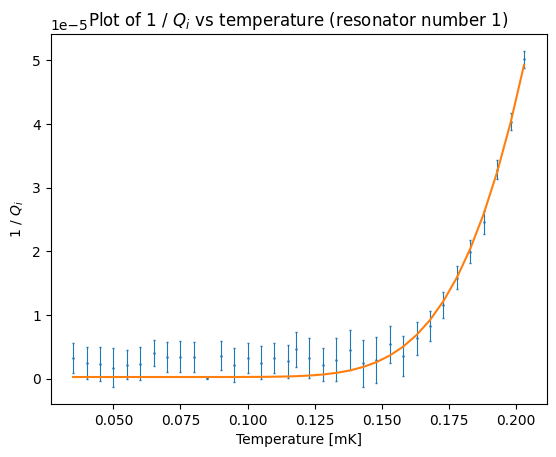

The interpolated value of the gap parameter is: ( 2.4366578303303753e-23 +- 4.940697815589998e-25 ) J
In terms of eV, it is: ( 0.15229111439564846 +- 0.003087936134743749 ) meV

RESONATOR NUMBER  2
┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 14.18 (chi2/ndof = 0.6)    │              Nfcn = 190              │
│ EDM = 1.23e-05 (Goal: 0.0002)    │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │       SOME Parameters at limit       │
├──────────────────────────────────┼──────────────────────────────────────┤
│ Below EDM threshold (goal x 10)  │           Below call limit           │
├───────────────┬──────────────────┼───────────┬─────────────┬────────────┤
│  Covariance   │     Hesse ok     │ Accur

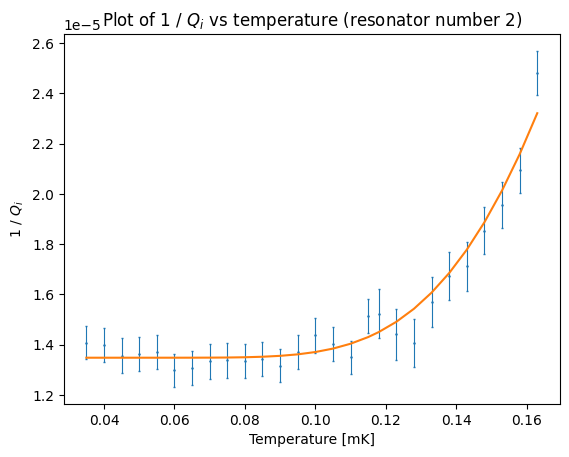

The interpolated value of the gap parameter is: ( 1.4930481239422796e-23 +- 1.3091474123027016e-25 ) J
In terms of eV, it is: ( 0.09331550774639248 +- 0.0008182171326891885 ) meV

RESONATOR NUMBER  3
There has been some trouble with the fit of the resonance number 3. 
 Make a check!
┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 10.81 (chi2/ndof = 0.5)    │              Nfcn = 396              │
│ EDM = 7.07e-06 (Goal: 0.0002)    │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │       SOME Parameters at limit       │
├──────────────────────────────────┼──────────────────────────────────────┤
│ Below EDM threshold (goal x 10)  │           Below call limit           │
├───────────────┬───────────────

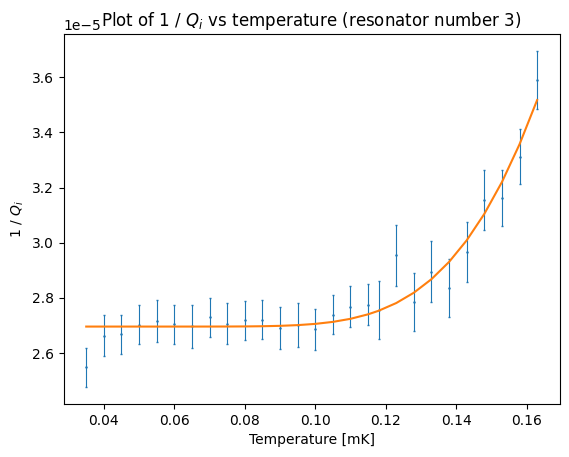

The interpolated value of the gap parameter is: ( 1.729623055948027e-23 +- 1.562613839946284e-24 ) J
In terms of eV, it is: ( 0.10810144099675169 +- 0.009766336499664276 ) meV

RESONATOR NUMBER  4
┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 11.63 (chi2/ndof = 0.6)    │              Nfcn = 73               │
│ EDM = 3.04e-05 (Goal: 0.0002)    │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │        No Parameters at limit        │
├──────────────────────────────────┼──────────────────────────────────────┤
│ Below EDM threshold (goal x 10)  │           Below call limit           │
├───────────────┬──────────────────┼───────────┬─────────────┬────────────┤
│  Covariance   │     Hesse ok     │ Accura

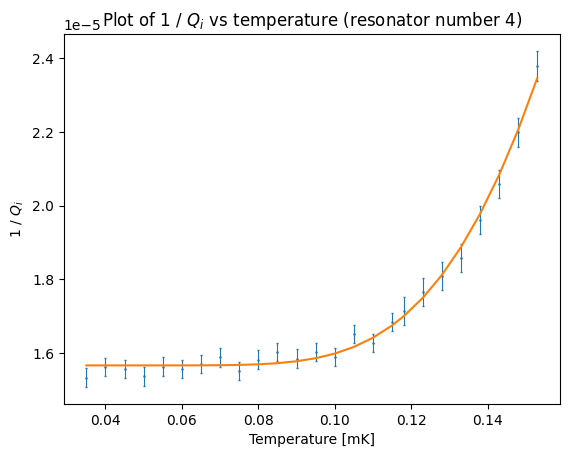

The interpolated value of the gap parameter is: ( 1.4163836532864448e-23 +- 4.936595921451742e-26 ) J
In terms of eV, it is: ( 0.0885239783304028 +- 0.0003085372450907339 ) meV

Recap:
delta (mev) = [0.15229111 0.09331551 0.10810144 0.08852398]
errors (mev) =  [0.00308794 0.00081822 0.00976634 0.00030854]


In [9]:
# Erase these lines when you're done with trial and error

suggestions_fit_inv_Q_i = np.zeros(shape=(10, 4))           # Attempt to automatize fit suggestions. Order of the array is: p_i_sugg, p_i_liminf, p_i_limsup for i in [1,3] and in the end p_4_sugg
suggestions_fit_inv_Q_i[:,0] = np.array([1e6, 30e3, 1e7, .85, 0.01, 0.99, 1.5e-23, 1.6e-24, 1e-22, 2* np.pi *5.5e6])
suggestions_fit_inv_Q_i[:,1] = np.array([71e3, 50e3, 90e3, .85, 0.01, 0.99, 1.4e-23, 1.6e-24, 1e-22, 2* np.pi *5.5e6]) 
suggestions_fit_inv_Q_i[:,2] = np.array([38e3, 30e3, 50e3, .85, 0.01, 0.99, 1.5e-23, 1.6e-24, 1e-22, 2* np.pi *5.5e6]) 
suggestions_fit_inv_Q_i[:,3] = np.array([71e3, 10e3, 90e3, .85, 0.01, 0.99, 1.4e-23, 1.6e-24, 1e-22, 2* np.pi *5.5e6])  

# Trying to fit

delta = np.zeros(shape = Q_i[0,:].shape)
delta_err = np.zeros(shape = Q_i[0,:].shape)

res = 0
lim_temp_index = np.array([35, 27, 27, 25])

for k in range(4):
    
    fit, m = fit_Qi_vs_temp(temps[:lim_temp_index[k]], inv_Q_i[:lim_temp_index[k],k], inv_Q_i_err[:lim_temp_index[k], k], suggestions_fit_inv_Q_i)        # Fit execution

    valid, accurate = fit_check(m)             #Fit check
    print('RESONATOR NUMBER ', k+1)
    if(valid == False or accurate == False):
        print('There has been some trouble with the fit of the resonance number ' + str(k+1) +'. \n Make a check!' )
    print(fit)
    
    plot_data_and_fit(temps[:lim_temp_index[k]], inv_Q_i[:lim_temp_index[k],k], inv_Qi_model(temps[:lim_temp_index[k]], *m.values), original_data_err=inv_Q_i_err[:lim_temp_index[k],k], x_axis = 'Temperature [mK]', y_axis = '1 / $Q_i$', title = 'Plot of 1 / $Q_i$ vs temperature (resonator number ' + str(k+1) + ')')
        
    delta[k]= fit.values["p3"]                  #Get the delta parameter
    delta_err[k] = fit.errors["p3"]
    
    print('The interpolated value of the gap parameter is: (', delta[k], '+-', delta_err[k], ') J')
    print('In terms of eV, it is: (', delta[k] / ( 1.6e-19) * 1e3, '+-', delta_err[k] / ( 1.6e-19) * 1e3,') meV\n' )
    res += 1

print('Recap:')
print('delta (mev) =', delta/ ( 1.6e-19) * 1e3)
print('errors (mev) = ', delta_err/ ( 1.6e-19) * 1e3)

$\color{green} \textbf{Second attempt for second fit: only 2 free parameters} \\ $

This time we try and fix the values of $\alpha=0.85$ and $\omega=2 \pi f_0$
We use as a model:
$\\ p_1 \longrightarrow Q_i(0) \\
p_2 =\alpha = 0.85 \hspace{.5cm} \text{\color{red} fixed} \\
p_3 \longrightarrow \Delta(0)\\
p_4 \longrightarrow \omega=2 \pi f_0 \hspace{.5cm} \text{\color{red} fixed (for each resonator)}$

In [ ]:
def fit_Qi_vs_temp_fixed(temp, inv_Q_i, inv_Q_i_err, suggestions, i):           # i is the number of resonance
    least_squares = LeastSquares(temp, inv_Q_i, inv_Q_i_err, inv_Qi_model)
    m = Minuit(least_squares, p1 = suggestions[0 , res], p2 = .90, p3 = suggestions[6 , res], p4 = res_freqs[i] * 1e9 * 2 *sc.pi)  # starting values for our parameters
    m.limits['p1'] = (suggestions[1 , res], suggestions[2 , res])           
    m.fixed['p2'] = .85
    m.limits['p3'] = (suggestions[7 , res], suggestions[8 , res])
    m.fixed['p4'] = res_freqs[i] *1e9
    fit = m.migrad()        # This is the command that performs the fit
    return fit, m 

# Erase these lines when you're done with trial and error

suggestions_fit_inv_Q_i = np.zeros(shape=(10, 4))           # Attempt to automatize fit suggestions. Order of the array is: p_i_sugg, p_i_liminf, p_i_limsup for i in [1,3] and in the end p_4_sugg
suggestions_fit_inv_Q_i[:,0] = np.array([1e6, 30e3, 5e6, .85, 0.01, 0.87, 1.5e-23, 1e-23, 3e-23, 2* np.pi *5.5e9])
suggestions_fit_inv_Q_i[:,1] = np.array([71e3, 50e3, 90e3, .85, 0.01, 0.87, 1.4e-23, 1e-23, 3e-23, 2* np.pi *5.5e9]) 
suggestions_fit_inv_Q_i[:,2] = np.array([38e3, 30e3, 50e3, .85, 0.01, 0.87, 1.5e-23, 1.1e-23, 3e-23, 2* np.pi *5.5e9]) 
suggestions_fit_inv_Q_i[:,3] = np.array([71e3, 10e3, 90e3, .85, 0.01, 0.87, 1.4e-23, 1e-23, 3e-23, 2* np.pi *5.5e9])  

# Trying to fit

delta = np.zeros(shape = Q_i[0,:].shape)
delta_err = np.zeros(shape = Q_i[0,:].shape)

res = 0
lim_temp_index = np.array([35, 27, 27, 22])

for k in range(4):
    
    fit, m = fit_Qi_vs_temp_fixed(temps[:lim_temp_index[k]], inv_Q_i[:lim_temp_index[k],k], inv_Q_i_err[:lim_temp_index[k], k], suggestions_fit_inv_Q_i, k)        # Fit execution

    valid, accurate = fit_check(m)             # Fit check
    print('RESONATOR NUMBER ', k+1)
    if(valid == False or accurate == False):
        print('There has been some trouble with the fit of the resonance number ' + str(k+1) +'. \n Make a check!' )
    print(fit)
    
    plot_data_and_fit(temps[:lim_temp_index[k]], inv_Q_i[:lim_temp_index[k],k], inv_Qi_model(temps[:lim_temp_index[k]], *m.values), original_data_err=inv_Q_i_err[:lim_temp_index[k],k], x_axis = 'Temperature [mK]', y_axis = '1 / $Q_i$', title = 'Plot of 1 / $Q_i$ vs temperature (resonator number ' + str(k+1) + ')')
        
    delta[k]= fit.values["p3"]                  # Get the delta parameter
    delta_err[k] = fit.errors["p3"]
    
    print('The interpolated value of the gap parameter is: (', delta[k], '+-', delta_err[k], ') J')
    print('In terms of eV, it is: (', delta[k] / ( 1.6e-19) * 1e3, '+-', delta_err[k] / ( 1.6e-19) * 1e3,') meV\n' )
    res += 1

print('Recap:')
print('delta (mev) =', delta/ ( 1.6e-19) * 1e3)
print('errors (mev) = ', delta_err/ ( 1.6e-19) * 1e3)

Average of our results


In [10]:
gap_measured = np.average(delta) / (1.6e-19) * 1000
sqrt_error_gap_measured = np.std(delta) / (1.6e-19) * 1000

print('The measured value of the gap is (averaged on the 4 reonances and withs std error): (', gap_measured, '+-', sqrt_error_gap_measured, ') mev')

T_c = 2
gap_0K = 1.764 * sc.k * T_c
print('BCS predicts (if T_c =', T_c,  'K) a gap of : ', gap_0K / (1.6e-19) * 1000, 'mev or ', gap_0K, 0 ,'J')



The measured value of the gap is (averaged on the 4 reonances and withs std error): ( 0.11055801036729886 +- 0.025151983864838006 ) mev
BCS predicts (if T_c = 2 K) a gap of :  0.3044331045 mev or  4.8709296720000005e-23 0 J
